### APTOS 2019 Blindness Detection
#### -Detect diabetic retinopathy to stop blindness before it's too late

#### What is diabetic retinopathy?
"Diabetic retinopathy is an eye condition that can cause vision loss and blindness in people who have diabetes. It affects blood vessels in the retina (the light-sensitive layer of tissue in the back of your eye).  

If you have diabetes, it’s important for you to get a comprehensive dilated eye exam at least once a year. Diabetic retinopathy may not have any symptoms at first — but finding it early can help you take steps to protect your vision." -https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy 

#### Real World Problem.
Currently trained technicians from Aravind Eye Hospital in India travel to rural areas where medical screening is difficult to conduct and capture images of retina, they then rely on hihgly trained doctors to review the images and provide diagnosis.
The goal is to scale their efforts through technology; to gain the ability to automatically screen images for disease and provide information on how severe the condition may be.

#### Mapping Real World Problem to a Machine Learning/Deep Learning Problem.
We are provided with data of thousands of images of Retina and we also have the corresponding diagnosis report for that image which tells us the siverity of diabetic retinopathy on a scale of 0-4.

This can be mapped to categorical classification problem, where our inputs will be images of retina and output will be a an integer between 0-4 where '0' means 'No DR' and '4' means 'Proliferative DR'.

#### Performance Metrics.

1. Confusion Matrix
2. Quadratic Weighted Kappa(QWK)
Kappa is a score which takes into account both accuracy of the model with respect to the doctor's diagnosis and also the agreement of the model and Doctor by chance it is represented by 'κ' and is defined as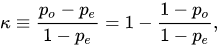
where po is the relative observed agreement among raters (identical to accuracy), and pe is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly seeing each category. If the raters are in complete agreement then kappa =1. If there is no agreement among the raters other than what would be expected by chance (as given by pe), kappa =0.

Weighted Kappa is a small variation to this, here if two raters disagree with each other then the score is given according to the distance of the ratings given by both raters.That means that our score will be higher if (a) the real value is 4 but the model predicts a as 3, and the score will be lower if (b) the model instead predicts a as 0.

In [274]:
import os
import math
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight, shuffle
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

#### 1. Exploratory Data Analysis and Feature Engineering

In [275]:
#fixing rnadom seed
np.random.seed(2020)
tf.random.set_seed(2020)
seed = 2020
IMG_SIZE=224

In [276]:
print(os.listdir('D:/Blindness Detection/'))

['2015_data', 'final.csv', 'model_base.h5', 'model_five.h5', 'model_four.h5', 'model_three.h5', 'model_two.h5', 'test.csv', 'test_images', 'train.csv', 'train_images', 'x_test_224_2019.npy', 'x_train_224_2019.npy', 'x_valid_224_2019.npy']


#### 1.1 Loding Data

Note that we are loading a csv which has filename in column 'id_code' and the corresponding diagnosis given by doctor in column 'diagnosis'.

In [277]:
df_train = pd.read_csv('D:/Blindness Detection//train.csv')
df_test = pd.read_csv('D:/Blindness Detection//test.csv')

df_train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

#### 1.2 Splitting the train data into train and validation sets.

In [279]:
id_code = df_train['id_code']
diagnosis = df_train['diagnosis']

id_code, diagnosis = shuffle(id_code, diagnosis, random_state=seed)

train_x, valid_x, train_y, valid_y = train_test_split(id_code, diagnosis, test_size=0.15, stratify=diagnosis, random_state=seed)

train_x = train_x.reset_index(drop=True)
valid_x = valid_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
valid_y = valid_y.reset_index(drop=True)


print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(df_test.shape)

(3112,)
(3112,)
(550,)
(550,)
(1928, 1)


#### 1.3 Plotting the distribution of files which belong to different classes

In [280]:

def plot_distribution(df, labels, t_cv_te='train'):
    '''
    This function prints the distribution of output variable in a given dataframe and also prints the stats
    '''
    print('-'*80)
    class_distribution = labels.value_counts().sort_index()
    class_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title('Distribution of yi in ' + t_cv_te + ' data')
    plt.grid()
    plt.show()

    sorted_yi = np.argsort(-class_distribution.values)
    for i in sorted_yi:
        print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/labels.shape[0]*100), 3), '%)')


--------------------------------------------------------------------------------


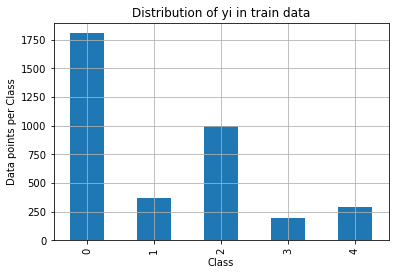

Number of data points in class 1 : 1805 ( 49.29 %)
Number of data points in class 3 : 999 ( 27.28 %)
Number of data points in class 2 : 370 ( 10.104 %)
Number of data points in class 5 : 295 ( 8.056 %)
Number of data points in class 4 : 193 ( 5.27 %)
--------------------------------------------------------------------------------


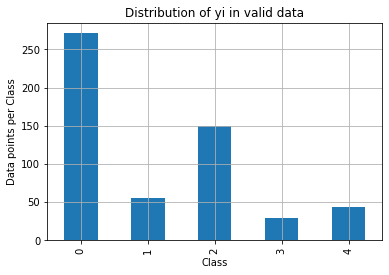

Number of data points in class 1 : 271 ( 49.273 %)
Number of data points in class 3 : 150 ( 27.273 %)
Number of data points in class 2 : 56 ( 10.182 %)
Number of data points in class 5 : 44 ( 8.0 %)
Number of data points in class 4 : 29 ( 5.273 %)


In [281]:
plot_distribution(df=df_train, labels=df_train['diagnosis'], t_cv_te='train')
plot_distribution(df=valid_x, labels=valid_y, t_cv_te='valid')

#### From the above distributions we can see that the classes 0 and 2 are dominant classes which means the data is imbalanced. Train and validation sets have similar percentage of images in each class.

#### 1.3 Image Preprocessing

#### 1.3.1 Image Features Enhancement

#### How do we know that a patient have diabetic retinopahy? There are at least 5 things to spot on. Image credit https://www.eyeops.com/
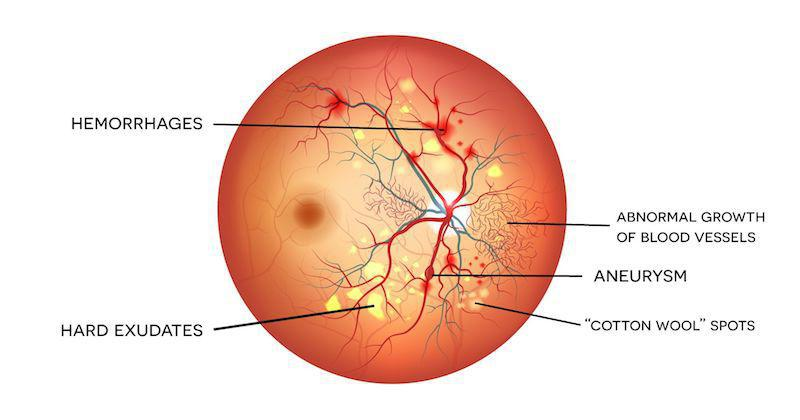

In [282]:
def image_preprocessing_1(df,labels,ben=False,sub_dir='train_images',sigmaX=10, ext='.png'):
    '''
    This function reads images, converts them to RGB, resizes the image to 256,256 shape and also enhances the images/
    by blending them with gaussianBluered version of itself
    '''
    fig = plt.figure(figsize=(25,16))

    for class_id in sorted(labels.unique()):
        for i, (idx, row) in enumerate(df.loc[df['diagnosis']==class_id].sample(5,random_state=seed).iterrows()):
            ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
            path="D:/Blindness Detection/"+sub_dir+'/'+row['id_code']+ext
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            if ben == True:

                
                image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),sigmaX),-4,128)
            plt.imshow(image)
            ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

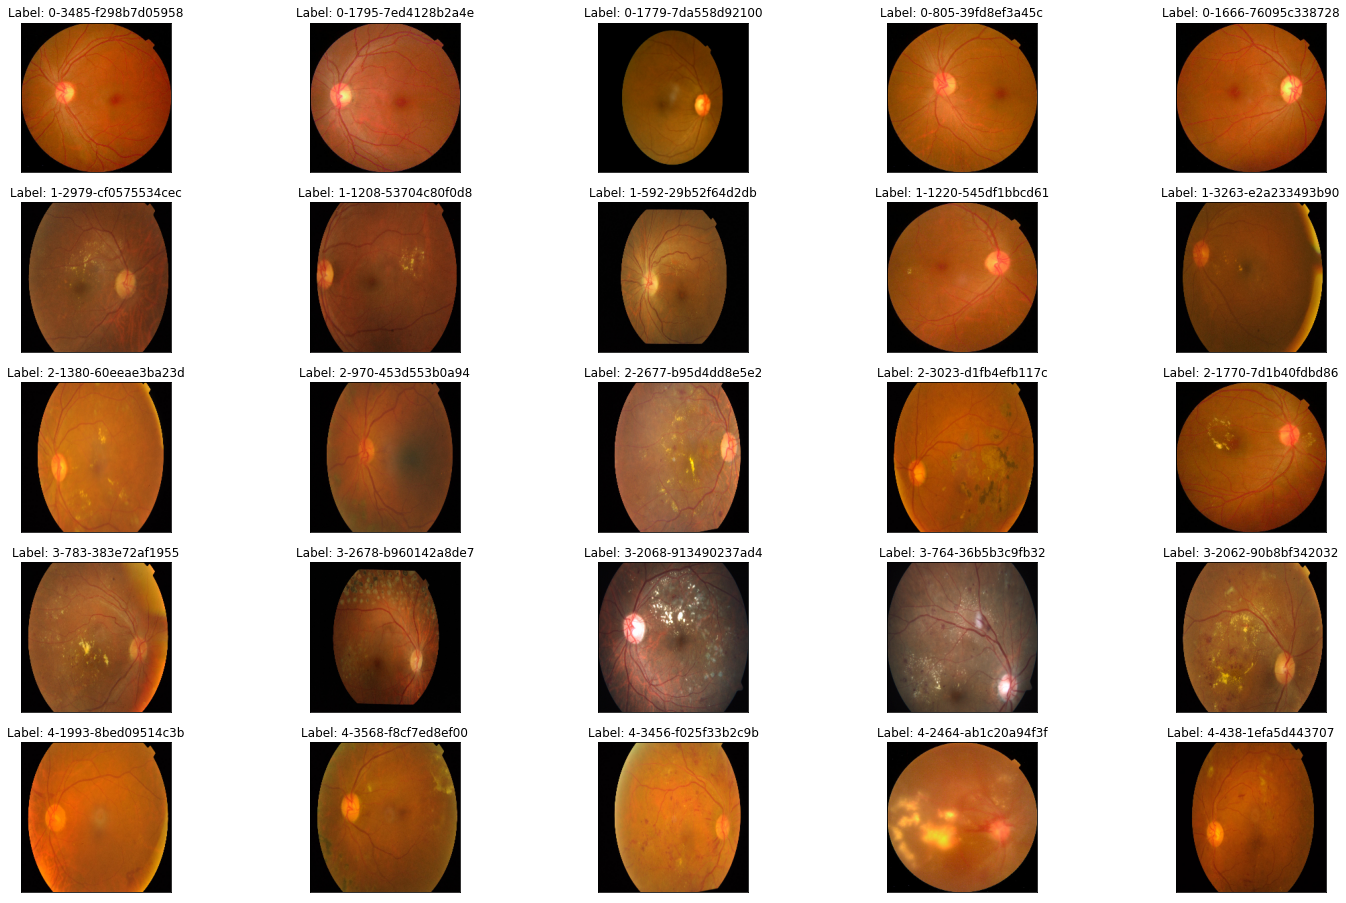

In [283]:
image_preprocessing_1(df_train,df_train['diagnosis'],ben=False,sub_dir = 'train_images')

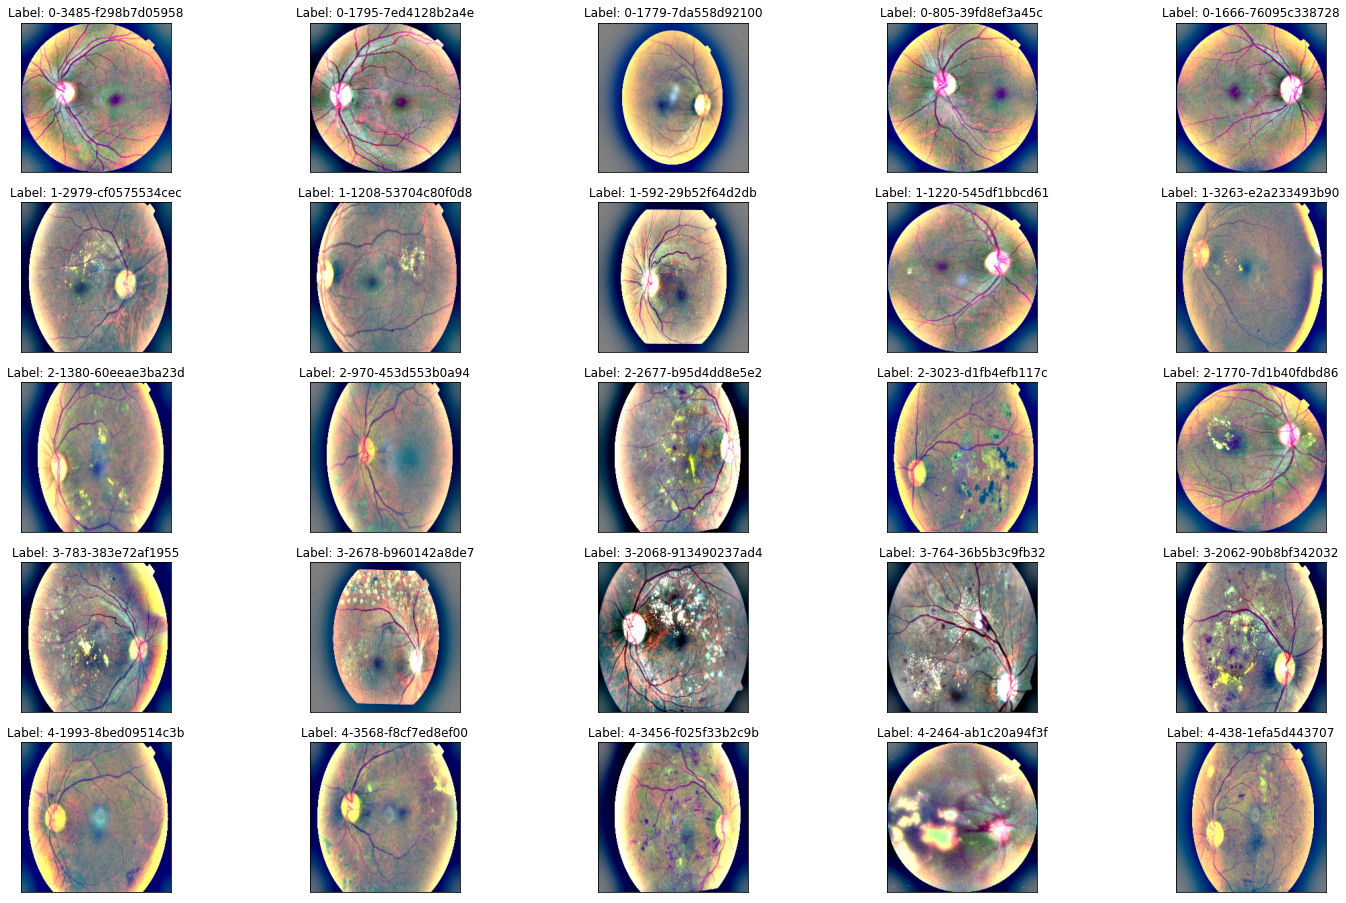

In [284]:
image_preprocessing_1(df_train,df_train['diagnosis'],ben=True,sub_dir = 'train_images',sigmaX=20)

#### From the above grids it is clear that the preprocessing has worked as the nerve,blood vessel features are visually more enhanced 

#### 1.3.2 Cropping dark edges from images

In [285]:
def crop_dark_extras(img,tol=7):
    '''
    This function is used to crop out the additions dark areas in the images as this information is not useful
    '''
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    

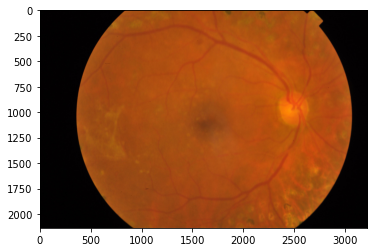

In [286]:
img = cv2.imread("D:/Blindness Detection/"+'train_images'+'/'+ df_train['id_code'][1] +'.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

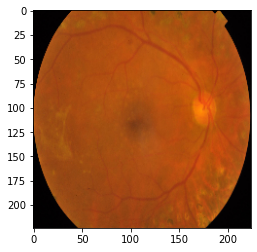

In [287]:
img = crop_dark_extras(img=img,tol=7)
img = cv2.resize(img, (224,224))
plt.imshow(img)

#### In the following cells the each image will be read from hard-disk, enchanced and also cropped, the resulting image is converted into an array representation and stored on disk 

In [288]:
def preprocess_image2(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 96)
    return image

In [289]:
def Preprocessing_images(df, sub_dir, ben=False, sigmaX=10, img_size=224, ext='.png'):
    '''
    This function reads images, converts them to RGB, resizes the image and also enhances the images/
    by blending them with gaussianBluered version of itself
    '''
    rows = df.shape[0]
    df_as_nd_array = np.empty((rows,img_size,img_size,3),dtype=np.uint8)

    for i,id_code in enumerate(tqdm(df)):
        path = "D:/Blindness Detection/"+sub_dir+'/'+ id_code + ext
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_dark_extras(img=img,tol=7)
        img = cv2.resize(img, (img_size,img_size))
        if ben == True:

            img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),sigmaX),-4,128)
        df_as_nd_array[i,:,:,:] = img
        
    return df_as_nd_array

In [290]:
if os.path.exists('D:/Blindness Detection/x_train_224_2019.npy'):
    x_train = np.load("D:/Blindness Detection/x_train_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_train = Preprocessing_images(df=train_x, sub_dir='train_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_train_224_2019', arr=x_train)
                 
if os.path.exists('D:/Blindness Detection/x_valid_224_2019.npy'):
    x_valid = np.load("D:/Blindness Detection/x_valid_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_valid = Preprocessing_images(df=valid_x, sub_dir='train_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_valid_224_2019', arr=x_valid)

print(x_train.shape)
print(x_valid.shape)

(3112, 224, 224, 3)
(550, 224, 224, 3)


In [291]:
if os.path.exists('D:/Blindness Detection/x_test_224_2019.npy'):
    x_test = np.load("D:/Blindness Detection/x_test_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_test = Preprocessing_images(df=df_test['id_code'], sub_dir='test_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_test_224_2019', arr=x_test)

print(x_test.shape)

(1928, 224, 224, 3)


#### 1.4 Transforming Output variables.


In [292]:
#below code converts categorical outputs into onhot encoded like vectors
y_train = pd.get_dummies(train_y).values
y_valid = pd.get_dummies(valid_y).values

print(y_train.shape)
print(y_valid.shape)

(3112, 5)
(550, 5)


In [293]:

def ordinal_regression(y):
    '''
    This function takes in the categorical(one hot encoded like) output varaible as input example [0,0,0,1,0] the output will be\
    [1,1,1,1,0] i.e all the categories before actual category are set to one
    '''
    y_multi = np.empty(y.shape, dtype=y.dtype)
    y_multi[:,4] = y[:,4] 

    for i in range(3,-1,-1):
        y_multi[:,i] = np.logical_or(y[:,i],y_multi[:,i+1])

    print(y_multi.shape)
    return y_multi

In [294]:
y_train=ordinal_regression(y_train)
y_valid=ordinal_regression(y_valid)

(3112, 5)
(550, 5)


In [295]:

def plot_confusion_matrix(test_y, predict_y):
    '''
    Utility function to plot confuion matirx/ classification report, precision and recall matrices
    '''
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 5,5 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)

    
    B =(C/C.sum(axis=0))
 
    
    labels = [1,2,3,4,5]
    cmap=sns.light_palette("purple")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

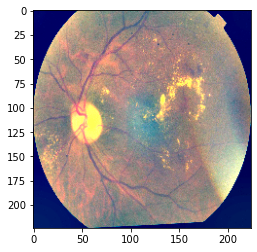

In [296]:
plt.imshow(x_train[1].reshape(IMG_SIZE,IMG_SIZE,3))

#### 2. Modelling

In [297]:
#sklearn's method
def cohen_kappa_score_cus(y1, y2, labels=None, weights="quadratic", sample_weight=None):
    confusion = confusion_matrix(y1, y2, labels=labels,
                                 sample_weight=sample_weight)
    n_classes = confusion.shape[0]
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)

    if weights is None:
        w_mat = np.ones([n_classes, n_classes], dtype=np.int)
        w_mat.flat[:: n_classes + 1] = 0
    elif weights == "linear" or weights == "quadratic":
        w_mat = np.zeros([n_classes, n_classes], dtype=np.int)
        w_mat += np.arange(n_classes)
        if weights == "linear":
            w_mat = np.abs(w_mat - w_mat.T)
        else:
            w_mat = (w_mat - w_mat.T) ** 2
    else:
        raise ValueError("Unknown kappa weighting type.")

    k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
    return 1 - k

In [298]:
'''
Custom metric function defined to get cohen kappa score 
'''
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.callbacks import Callback, ModelCheckpoint

def kappa(y_true, y_pred):
        
        y_actual = tf.cast(tf.math.reduce_sum(y_true,axis=1)- 1,dtype=tf.int32)
        y_pred = tf.cast(y_pred,dtype=tf.float32)
        limit = tf.constant([0.5],dtype=tf.float32)
    
        y_pred_reversed = tf.reverse(tf.math.greater(y_pred,limit),axis=[1])
        y_pred_reversed = tf.cast(y_pred_reversed,tf.int32)
    
        indices = tf.math.argmax(y_pred_reversed,axis=1)
        y_pred_ordinal = 4-indices
        y_pred_ordinal = tf.cast(y_pred_ordinal,tf.int32)
        
        
        # calculating using sklearn's kappa socre function
        val_kappa = tf.py_function(cohen_kappa_score_cus,[y_actual,y_pred_ordinal,],tf.double)
#         print(f"val_kappa: {val_kappa:.4f}")
        return val_kappa

#### 2.1 Models with self built architectures

#### 2.1.1 Baseline Model with simple architecture:

In [299]:
import keras as keras
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Reshape, Permute, Activation
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard , EarlyStopping
import time

In [300]:
Name = "Model_baseline_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))

model_base = tf.keras.Sequential()
model_base.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3),padding='same',
                 activation='relu',
                 input_shape=(IMG_SIZE,IMG_SIZE,3)))

model_base.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
model_base.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_base.add(tf.keras.layers.Dropout(0.3))


model_base.add(tf.keras.layers.Flatten())

model_base.add(tf.keras.layers.BatchNormalization())

model_base.add(tf.keras.layers.Dense(5, activation='sigmoid'))

model_base.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(decay=0.001),
              metrics=[kappa])

filepath="weights_baseline.best.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoint] + [tensorboard]

model_base.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 401408)            0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 401408)            1605632   
_________________________________________________________________
dense_40 (Dense)             (None, 5)               

In [301]:
history=model_base.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=1)

Train on 3112 samples, validate on 550 samples
Epoch 1/10
3072/3112 [============================>.] - ETA: 1s - loss: 1.4335 - kappa: 0.5159
Epoch 00001: val_kappa improved from -inf to 0.13363, saving model to weights_baseline.best.hdf5
3112/3112 [==============================] - 162s 52ms/sample - loss: 1.4281 - kappa: 0.5132 - val_loss: 4.6514 - val_kappa: 0.1336
Epoch 2/10
3072/3112 [============================>.] - ETA: 1s - loss: 0.5604 - kappa: 0.6594
Epoch 00002: val_kappa improved from 0.13363 to 0.50154, saving model to weights_baseline.best.hdf5
3112/3112 [==============================] - 158s 51ms/sample - loss: 0.5612 - kappa: 0.6573 - val_loss: 1.2737 - val_kappa: 0.5015
Epoch 3/10
3072/3112 [============================>.] - ETA: 1s - loss: 0.4086 - kappa: 0.7355
Epoch 00003: val_kappa improved from 0.50154 to 0.68223, saving model to weights_baseline.best.hdf5
3112/3112 [==============================] - 154s 49ms/sample - loss: 0.4083 - kappa: 0.7371 - val_loss: 0.

In [302]:
model_base.save('D:/Blindness Detection/model_base.h5')

In [303]:
from keras.models import load_model


In [304]:
model_base.load_weights(filepath)
score = model_base.evaluate(x_valid, y_valid, verbose=2)
print('val loss:', score[0])
print('val kappa:', score[1])


550/550 - 9s - loss: 0.8329 - kappa: 0.6619
val loss: 0.8328625339811498
val kappa: 0.6618849


In [189]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_base.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  38.54545454545455
-------------------------------------------------- Confusion matrix --------------------------------------------------


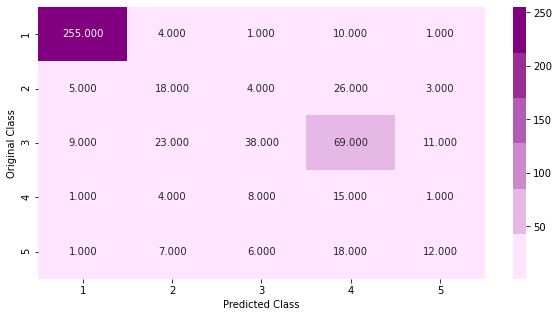

-------------------------------------------------- Precision matrix --------------------------------------------------


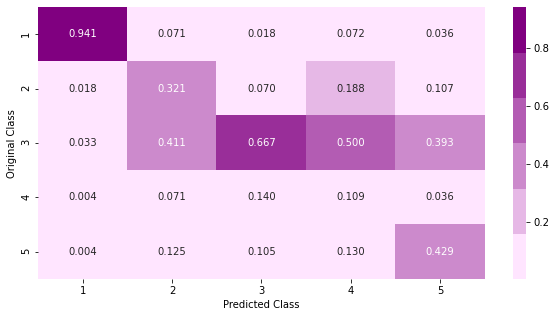

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


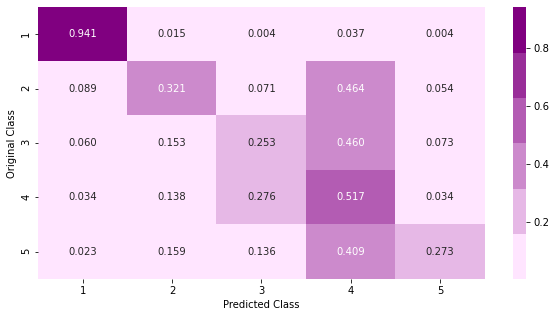

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [190]:
plot_confusion_matrix(actual_y, y_pred)

#### 2.1.2 Trying out with a deeper and wider model to see if there are any improvements.

In [173]:
Name = "Model_second_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))

model_two = tf.keras.Sequential()
model_two.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3,\
                         padding='same',\
                         activation='relu', \
                         kernel_initializer = 'he_normal',\
                         input_shape=(224,224,3)))
        
model_two.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        
model_two.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5,\
                                   activation='relu',\
                                   kernel_initializer = 'he_normal',\
                                   padding='same'))
                  
model_two.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5,\
                                   activation='relu',\
                                   kernel_initializer = 'he_normal',\
                                   padding='same'))
                  
model_two.add(tf.keras.layers.BatchNormalization())
                  
model_two.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model_two.add(tf.keras.layers.Dropout(0.5))
        
model_two.add(tf.keras.layers.Flatten())

model_two.add(tf.keras.layers.Dense(64, kernel_initializer = 'he_normal', activation='relu'))
        
model_two.add(tf.keras.layers.BatchNormalization())
        
model_two.add(tf.keras.layers.Dropout(0.5))

model_two.add(tf.keras.layers.Dense(5, activation='sigmoid'))

model_two.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(decay=0.001),
              metrics=[kappa])

filepath="weights_two.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_two.summary()


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 112, 112, 32)      12832     
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_30 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 56, 56, 64)      

In [174]:
history_two =model_two.fit(x_train, y_train,
          batch_size=16,
          epochs=10,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=2)

Train on 3112 samples, validate on 550 samples
Epoch 1/10

Epoch 00001: val_kappa improved from -inf to 0.66561, saving model to weights_two.hdf5
3112/3112 - 385s - loss: 0.5404 - kappa: 0.1653 - val_loss: 0.3333 - val_kappa: 0.6656
Epoch 2/10

Epoch 00002: val_kappa did not improve from 0.66561
3112/3112 - 398s - loss: 0.3344 - kappa: 0.5504 - val_loss: 18.9996 - val_kappa: 0.2418
Epoch 3/10

Epoch 00003: val_kappa did not improve from 0.66561
3112/3112 - 391s - loss: 0.2781 - kappa: 0.6622 - val_loss: 0.5843 - val_kappa: 0.6268
Epoch 4/10

Epoch 00004: val_kappa improved from 0.66561 to 0.70543, saving model to weights_two.hdf5
3112/3112 - 385s - loss: 0.2596 - kappa: 0.6712 - val_loss: 0.2495 - val_kappa: 0.7054
Epoch 5/10

Epoch 00005: val_kappa did not improve from 0.70543
3112/3112 - 376s - loss: 0.2544 - kappa: 0.6745 - val_loss: 1.0663 - val_kappa: 0.6920
Epoch 6/10

Epoch 00006: val_kappa did not improve from 0.70543
3112/3112 - 372s - loss: 0.2375 - kappa: 0.7133 - val_loss: 

In [175]:
model_two.save('D:/Blindness Detection/model_two.h5')

In [176]:
from keras.models import load_model

#model_two = load_model('new_kappa_models/model_two.h5')

In [177]:
model_two.load_weights(filepath)
score_two = model_two.evaluate(x_valid, y_valid, verbose=2)
print('val loss:', score_two[0])
print('val kappa:', score_two[1])

550/550 - 19s - loss: 0.2229 - kappa: 0.7323
val loss: 0.22291824237866836
val kappa: 0.7323117


In [178]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_two.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1

Number of misclassified points  28.000000000000004
-------------------------------------------------- Confusion matrix --------------------------------------------------


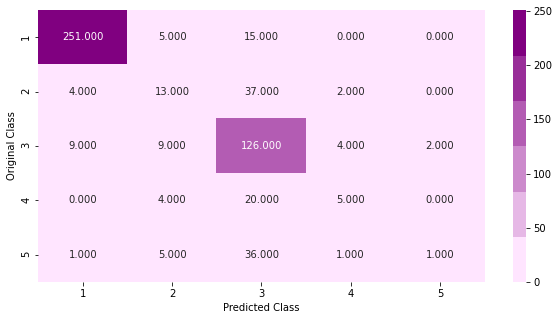

-------------------------------------------------- Precision matrix --------------------------------------------------


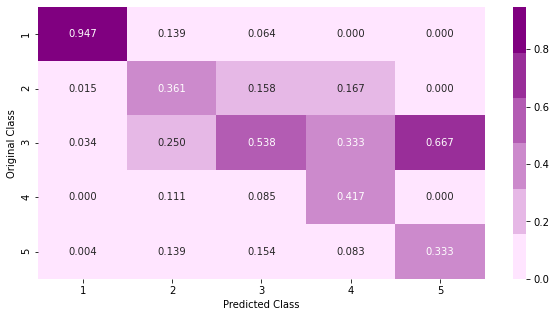

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


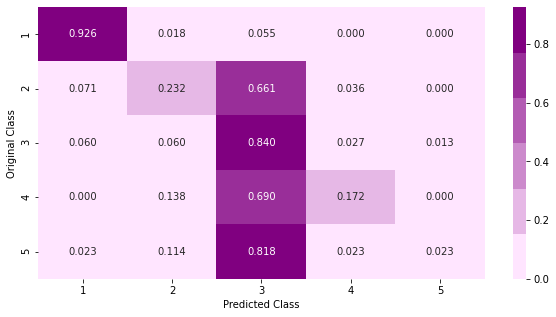

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [181]:
actual_y = y_valid.sum(axis=1) - 1 

plot_confusion_matrix(actual_y, y_pred)

#### From the above confusion matrices we can see that  model_two has improved from our baseline model performance on classes 4 and 5 has also improved to a certain extent yet the dominance of class 3 is still evident.

#### 2.2.1 Transfer Learning with Image Augmentation.

#### Data Augmentation Technique-Image Data Generator.

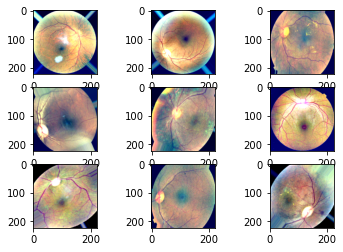

In [224]:

from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,validation_split=0.15,)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(x_batch[i].astype('uint8'))
	# show the plot
	pyplot.show()
	break

In [225]:
training_generator = datagen.flow(x_train, y_train, batch_size=8,subset='training',seed=7)
validation_generator = datagen.flow(x_train, y_train, batch_size=8,subset='validation',seed=7)


In [216]:
# datagen=ImageDataGenerator(horizontal_flip=True,
#                            vertical_flip=True,
#                            rotation_range=180,
#                            rescale=1./255.,
#                            validation_split=0.15,
#                            preprocessing_function=preprocess_image2)
# training_generator = datagen.flow(x_train, y_train, batch_size=8,subset='training',seed=7)
# validation_generator = datagen.flow(x_train, y_train, batch_size=8,subset='validation',seed=7)

# DenseNet121

In [195]:
from keras.applications import DenseNet121

Name = "Model_image_gen_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))

densenet = tf.keras.applications.DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_three = tf.keras.Sequential()
model_three.add(densenet)
model_three.add(tf.keras.layers.GlobalAveragePooling2D())
model_three.add(tf.keras.layers.Dropout(0.5))
model_three.add(tf.keras.layers.Dense(5, activation='sigmoid'))
    
model_three.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="weights_image_gen.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_three.summary()


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [197]:
history_three =model_three.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=10,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 8,
                    callbacks=callbacks_list)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 389.0 steps, validate on 550 samples
Epoch 1/10
388/389 [============================>.] - ETA: 4s - loss: 0.3928 - kappa: 0.5058
Epoch 00001: val_kappa improved from -inf to 0.73290, saving model to weights_image_gen.hdf5
389/389 [==============================] - 1867s 5s/step - loss: 0.3925 - kappa: 0.5059 - val_loss: 0.2167 - val_kappa: 0.7329
Epoch 2/10
388/389 [============================>.] - ETA: 4s - loss: 0.1990 - kappa: 0.7821
Epoch 00002: val_kappa improved from 0.73290 to 0.81111, saving model to weights_image_gen.hdf5
389/389 [==============================] - 1733s 4s/step - loss: 0.1991 - kappa: 0.7821 - val_loss: 0.1787 - val_kappa: 0.8111
Epoch 3/10
388/389 [============================>.] - ETA: 4s - loss: 0.1625 - kappa: 0.8107
Epoch 00003: val_kappa improved from 0.81111 to 0.84026, saving model to weights_image_gen.hdf5
389/389 [=========================

In [198]:
model_three.save('D:/Blindness Detection/model_three.h5')


In [200]:
model_three.load_weights(filepath)
score_three = model_three.evaluate(x_valid, y_valid, verbose=2)
print('val loss:', score_three[0])
print('val kappa:', score_three[1])

y_pred = model_three.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

550/550 - 83s - loss: 0.1619 - kappa: 0.8737
val loss: 0.1619095859608867
val kappa: 0.873732


Number of misclassified points  20.363636363636363
-------------------------------------------------- Confusion matrix --------------------------------------------------


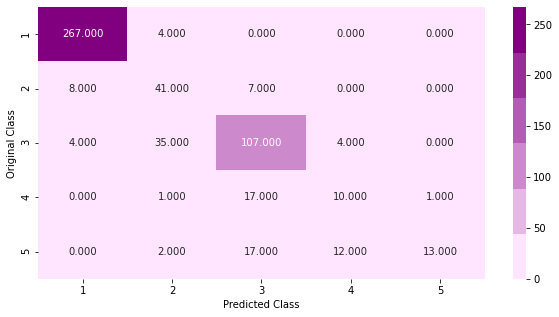

-------------------------------------------------- Precision matrix --------------------------------------------------


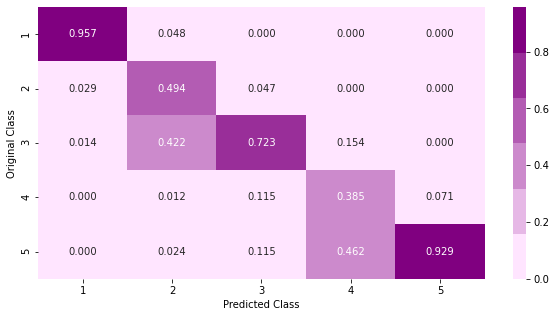

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


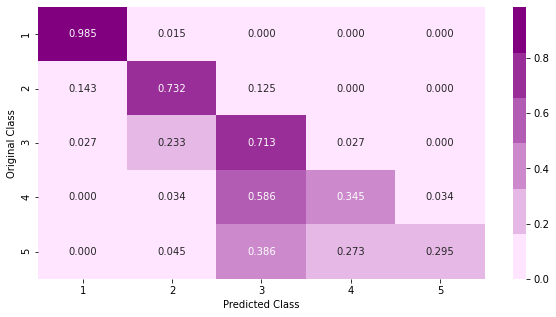

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [201]:
plot_confusion_matrix(actual_y, y_pred)

# Resnet50 

In [222]:
from keras_applications.resnet import ResNet50

Name = "Model_four-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))

resnet = tf.keras.applications.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_four = tf.keras.Sequential([
resnet,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(5, activation='sigmoid')
])
    

model_four.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])

    
filepath="weights_four.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_four.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [223]:
history_four =model_four.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) // 8,
                    epochs=10,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) // 8,
                    callbacks=callbacks_list)

  ...
    to  
  ['...']
Train for 389 steps, validate on 550 samples
Epoch 1/10
388/389 [============================>.] - ETA: 4s - loss: 0.2353 - kappa: 0.7195
Epoch 00001: val_kappa improved from -inf to 0.81833, saving model to weights_four.hdf5
389/389 [==============================] - 1888s 5s/step - loss: 0.2349 - kappa: 0.7202 - val_loss: 0.1648 - val_kappa: 0.8183
Epoch 2/10
388/389 [============================>.] - ETA: 4s - loss: 0.1606 - kappa: 0.8221
Epoch 00002: val_kappa improved from 0.81833 to 0.84194, saving model to weights_four.hdf5
389/389 [==============================] - 1857s 5s/step - loss: 0.1606 - kappa: 0.8219 - val_loss: 0.1380 - val_kappa: 0.8419
Epoch 3/10
388/389 [============================>.] - ETA: 4s - loss: 0.1397 - kappa: 0.8490
Epoch 00003: val_kappa improved from 0.84194 to 0.85144, saving model to weights_four.hdf5
389/389 [==============================] - 1858s 5s/step - loss: 0.1399 - kappa: 0.8491 - val_loss: 0.1381 - val_kappa: 0.8514


In [226]:
model_four.save('D:/Blindness Detection/model_four.h5')


In [227]:
model_four.load_weights(filepath)
score_four = model_four.evaluate(x_valid, y_valid, verbose=2)
print('val loss:', score_four[0])
print('val kappa:', score_four[1])




550/550 - 101s - loss: 0.1495 - kappa: 0.8803
val loss: 0.14953927435658196
val kappa: 0.88029104


In [228]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_four.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  20.18181818181818
-------------------------------------------------- Confusion matrix --------------------------------------------------


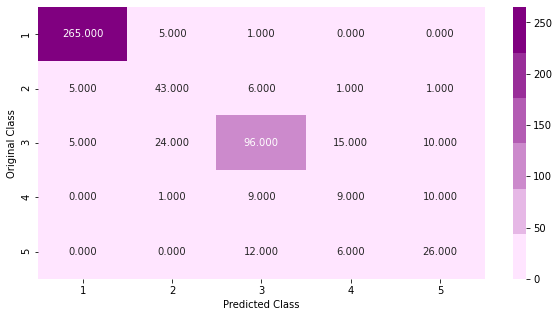

-------------------------------------------------- Precision matrix --------------------------------------------------


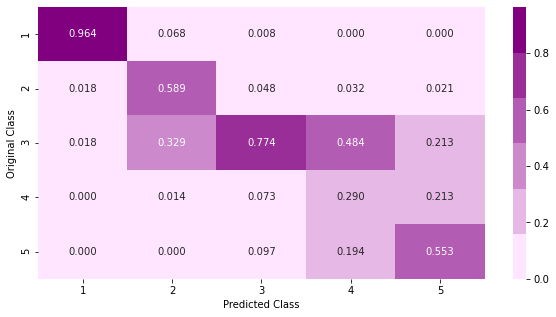

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


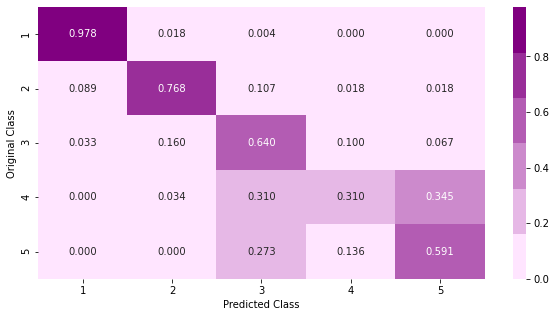

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [229]:
plot_confusion_matrix(actual_y, y_pred)

Text(0.5, 0, 'Epoch')

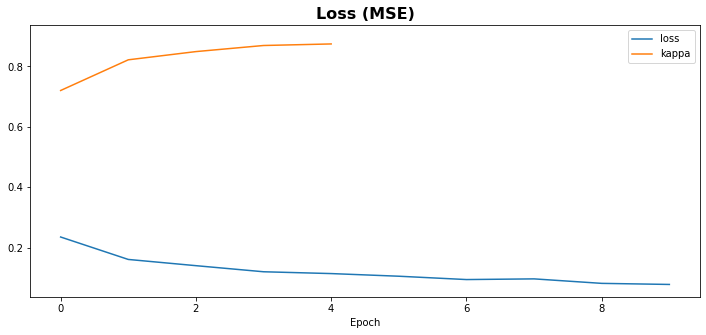

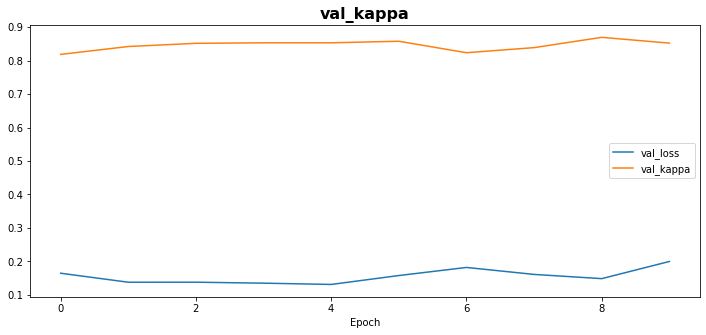

In [306]:
history_df = pd.DataFrame(model_four.history.history)
history_df[['loss','kappa']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
history_df[['val_loss', 'val_kappa']].plot(figsize=(12,5))
plt.title("val_kappa", fontsize=16, weight='bold')
plt.xlabel("Epoch")


In [232]:
history_df.head()

loss     kappa  val_loss  val_kappa
0  0.234879  0.720225  0.164841   0.818326
1  0.160552  0.821867  0.137970   0.841940
2  0.139927  0.849078  0.138068   0.851444
3  0.119750  0.869270  0.135161   0.853003
4  0.113735  0.874421  0.131348   0.852992

In [236]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int((len(x_train)*0.15)//8)):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [237]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model_four, training_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model_four, validation_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

The Training Cohen Kappa Score is: 0.91512
The Validation Cohen Kappa Score is: 0.92811


# Efficientnet-B4 

From all the above models we can see that the Metrics function sometimes output nan instead of the actual value .
This is due to the small batch size as there are only 4 or 8 images(maximum that can be accomodated by GTX 1050) per batch most of them might belong to one or two of the 5 calsses due to which the normalization present in the cohen_kappa_score function goes for a toss and this also cannot be omitted.
Hence we shall implement a callback function which predicts the kappa score on the validation set after each epoch in this final model and plot the progress of kappa score manually instead of using tensorboard.
we are also saving the best model which has the best Kappa score in Metrics() callback

In [238]:



class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model_five, validation_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

In [241]:
import efficientnet.tfkeras as efn
# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB4.h5'

Name = "Model_five-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))

effnet = efn.EfficientNetB4(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_five = tf.keras.Sequential([
effnet,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(5, activation='sigmoid')
])
       
model_five.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=0.00005))

    
filepath = "weights_five.hdf5"

#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

kappa_metrics = Metrics()

callbacks_list = [checkpoint] + [tensorboard] + [kappa_metrics]

model_five.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1792)              0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 1792)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [242]:
history_five = model_five.fit_generator(training_generator,
                              steps_per_epoch=(len(x_train)*0.85)//8,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(x_train)*0.15)//8,
                              callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 330.0 steps, validate for 58.0 steps
Epoch 1/10
329/330 [============================>.] - ETA: 6s - loss: 0.3459 val_kappa: 0.8404
Validation Kappa has improved. Saving model.
330/330 [==============================] - 2416s 7s/step - loss: 0.3452 - val_loss: 0.1900
Epoch 2/10
329/330 [============================>.] - ETA: 6s - loss: 0.1896 val_kappa: 0.8687
Validation Kappa has improved. Saving model.
330/330 [==============================] - 2336s 7s/step - loss: 0.1896 - val_loss: 0.1475
Epoch 3/10
329/330 [============================>.] - ETA: 6s - loss: 0.1587 val_kappa: 0.8919
Validation Kappa has improved. Saving model.
330/330 [==============================] - 2329s 7s/step - loss: 0.1588 - val_loss: 0.1337
Epoch 4/10
329/330 [============================>.] - ETA: 6s - loss: 0.1406 val_kappa: 0.8985
Validation Kappa has improved. Saving model.
330/330 [==============================] - 2300s 7s/step - loss: 0.140

In [246]:
# from keras.models import load_model
# model_five.save('D:/Blindness Detection/model_five.h5')

In [266]:
model_five.load_weights(SAVED_MODEL_NAME)
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model_five, training_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model_five, validation_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

The Training Cohen Kappa Score is: 0.94688
The Validation Cohen Kappa Score is: 0.89976


In [251]:
y_pred = model_five.predict(x_valid,batch_size=4) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  23.454545454545457
-------------------------------------------------- Confusion matrix --------------------------------------------------


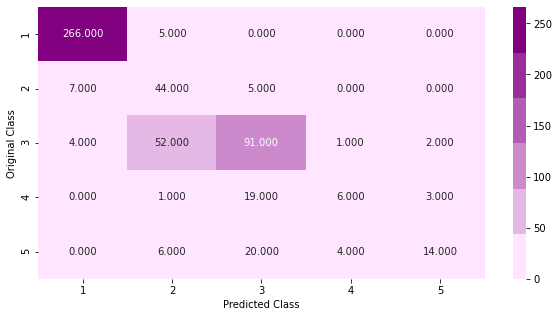

-------------------------------------------------- Precision matrix --------------------------------------------------


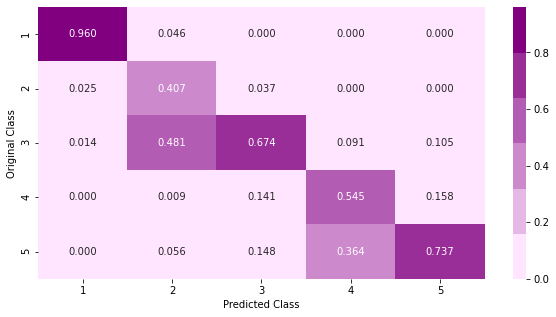

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


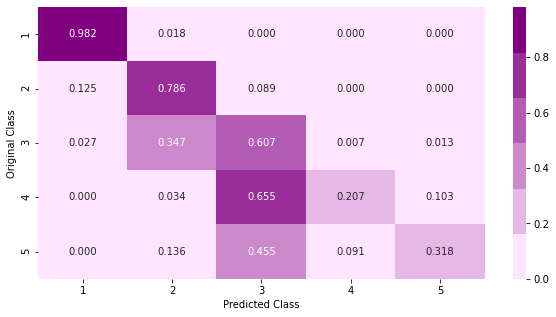

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [252]:
plot_confusion_matrix(actual_y, y_pred)

#### Plot for Validation Kappa Score

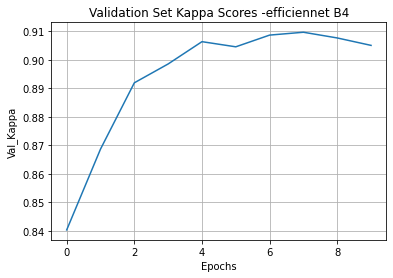

In [259]:
Val_kappa_scores_final_model=[0.8404, 0.8687,0.8919,0.8985,0.9063,0.9045,0.9086,0.9096,0.9076,0.905]
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Val_Kappa")
plt.title("Validation Set Kappa Scores -efficiennet B4")
plt.plot(Val_kappa_scores_final_model)

#### 3. Conclusion 

In [263]:

from prettytable import PrettyTable

x = PrettyTable()


x.add_column('Model',['Model_base','Model_two','Model_three','Model_four','Model_five'])
x.add_column('trainable params',['2,814,949','12,910,245','6,958,981','23,544,837','17,557,581'])
x.add_column('Kappa',[0.9655,0.7336,0.8931,0.8803,'-'])
x.add_column('val_kappa',[0.7070,0.7443,0.8705,0.8802,0.9076])


print(x)
print('Model_base =  self built simple architectures')
print('Model_two = self built architectures - deeper and wider model')
print("Model_three= densenet121 with imagenet weights and Image Augmentation")
print("Model_four= resnet50 with with imagenet weights and Image Augmentation")
print("Model_fivw = effnetB4 with with imagenet weights and Image Augmentation")

x.clear()

+-------------+------------------+--------+-----------+
|    Model    | trainable params | Kappa  | val_kappa |
+-------------+------------------+--------+-----------+
|  Model_base |    2,814,949     | 0.9655 |   0.707   |
|  Model_two  |    12,910,245    | 0.7336 |   0.7443  |
| Model_three |    6,958,981     | 0.8931 |   0.8705  |
|  Model_four |    23,544,837    | 0.8803 |   0.8802  |
|  Model_five |    17,557,581    |   -    |   0.9076  |
+-------------+------------------+--------+-----------+
Model_base =  self built simple architectures
Model_two = self built architectures - deeper and wider model
Model_three= densenet121 with imagenet weights and Image Augmentation
Model_four= resnet50 with with imagenet weights and Image Augmentation
Model_fivw = effnetB4 with with imagenet weights and Image Augmentation


#### Creating Test Labels.

In [269]:
y_pred = model_five.predict(x_test,batch_size=4) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.astype(int).sum(axis=1)-1


In [271]:

df_test['diagnosis'] = y_pred
df_test.to_csv('final.csv',index=False)

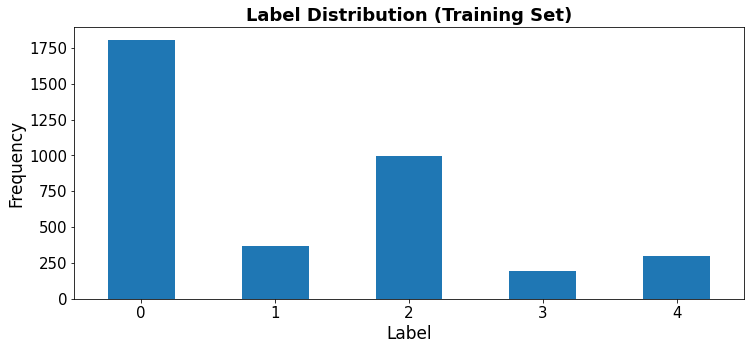

In [272]:
# Label distribution
df_train['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

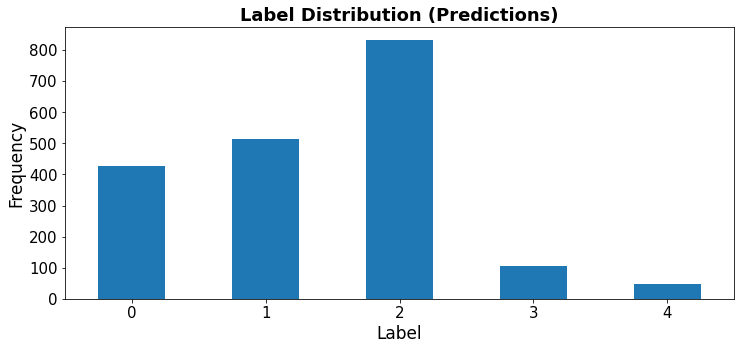

In [273]:
# Distribution of predictions
df_test['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);